In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse
from lightfm import LightFM
from tqdm.auto import tqdm

from recommender.testing.custom_metric_utils import calculate_metric_scores
from recommender.testing.custom_metric_utils import create_recommendations_profiles_embeddings
from recommender.tools.lightfm_utils import LightFMTests

In [2]:
DATA_ROOT = '../../data'
THREADS = 8

## Data loading

In [3]:
full_df = pd.read_csv(f'{DATA_ROOT}/ratings_all_implicit.csv.gz')
train_df = pd.read_csv(f'{DATA_ROOT}/ratings_train_implicit.csv.gz')
games_df = pd.read_json(f'{DATA_ROOT}/bgg_GameItem.jl', lines=True)[[
    'name', 'bgg_id', 'mechanic', 'category', 'complexity',
    'max_players_best', 'min_players_best', 'max_players_rec', 'min_players_rec'
]]

features_names = pd.read_csv(f'{DATA_ROOT}/game_features_names.csv.gz').values.flatten()
game_features = pd.read_csv(f'{DATA_ROOT}/game_features.csv.gz')

dataset = pd.read_pickle(f'{DATA_ROOT}/dataset.pkl')
item_features = pd.read_pickle(f'{DATA_ROOT}/item_features.pkl')

train_interactions = scipy.sparse.load_npz(f'{DATA_ROOT}/train_interactions.npz')
test_interactions = scipy.sparse.load_npz(f'{DATA_ROOT}/test_interactions.npz')

In [4]:
users_profiles = pd.read_pickle(f'{DATA_ROOT}/users_profiles.pkl')
test_users_profiles = pd.read_pickle(f'{DATA_ROOT}/test_users_profiles.pkl')
games_profiles = pd.read_pickle(f'{DATA_ROOT}/games_profiles.pkl')

## Data processing

In [5]:
mechanics_names = features_names[:20]
categories_names = features_names[20:40]

In [6]:
users_profiles.index = users_profiles.index.map(dataset.mapping()[0])
test_users_profiles.index = test_users_profiles.index.map(dataset.mapping()[0])
games_profiles.index = games_profiles.index.map(dataset.mapping()[2])
users_profiles = users_profiles.sort_index()
test_users_profiles = test_users_profiles.sort_index()
games_profiles = games_profiles.sort_index()

In [7]:
users_profiles.values[:, :40] *= 3
test_users_profiles.values[:, :40] *= 3

In [8]:
cython_users_profiles = np.ascontiguousarray(users_profiles.values, dtype=np.float32)
cython_games_profiles = np.ascontiguousarray(games_profiles.values, dtype=np.float32)

In [9]:
users_profiles

,Card Game:1002,Children's Game:1041,Wargame:1019,Party Game:1030,Dice:1017,Abstract Strategy:1009,Educational:1094,Fantasy:1010,Trivia:1027,Print & Play:1120,...,Complexity: 2.75,Complexity: 3.0,Complexity: 3.25,Complexity: 3.5,Complexity: 3.75,Complexity: 4.0,Complexity: 4.25,Complexity: 4.5,Complexity: 4.75,Complexity: 5.0
bgg_user_name,,,,,,,,,,,,,,,,,,,,,
0,0.185567,0.000000,0.463918,0.092784,0.030928,0.030928,0.000000,0.587629,0.092784,0.000000,...,0.853234,0.719884,0.559403,0.406612,0.257378,0.145929,0.067505,0.018451,0.004133,0.000000
1,0.750000,0.000000,0.300000,0.150000,0.300000,0.150000,0.000000,0.750000,0.000000,0.000000,...,0.483044,0.249050,0.138632,0.090537,0.061403,0.032269,0.003135,0.000000,0.000000,0.000000
2,0.588106,0.019824,0.218062,0.158590,0.118943,0.052863,0.019824,0.383260,0.019824,0.026432,...,0.868630,0.743872,0.607954,0.476589,0.346595,0.222867,0.122381,0.054664,0.016911,0.003608
3,0.900000,0.000000,0.300000,0.300000,0.000000,0.300000,0.000000,0.000000,0.000000,0.000000,...,0.593081,0.391888,0.211645,0.112041,0.036678,0.004190,0.000000,0.000000,0.000000,0.000000
4,0.512953,0.031088,0.481865,0.170984,0.062176,0.077720,0.031088,0.388601,0.015544,0.000000,...,0.990435,0.934503,0.804351,0.653234,0.457367,0.275569,0.145674,0.058051,0.026715,0.013000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255145,0.315789,0.078947,0.078947,0.157895,0.078947,0.078947,0.000000,0.315789,0.000000,0.000000,...,0.747608,0.907259,1.000000,0.933529,0.798113,0.511489,0.261847,0.113695,0.011540,0.000000
255146,0.731707,0.073171,0.000000,0.219512,0.073171,0.000000,0.073171,0.219512,0.000000,0.000000,...,0.956630,0.852300,0.680646,0.470204,0.321035,0.193476,0.123478,0.066910,0.032190,0.016567
255147,0.613043,0.013043,0.039130,0.273913,0.182609,0.104348,0.000000,0.234783,0.039130,0.052174,...,0.852718,0.753342,0.621258,0.499052,0.390478,0.284043,0.203207,0.132108,0.077190,0.038711


## Training & evaluating

In [10]:
PARAMS = {'no_components': 70,
          'learning_schedule': 'adadelta',
          'loss': 'custom',
          'item_alpha': 3e-06,
          'max_sampled': 10,
          'rho': 0.95,
          'epsilon': 1.0e-06,
          'random_state': 42}

model = LightFM(**PARAMS)

random.seed(42)
np.random.seed(42)

random_users_id = np.random.choice(test_users_profiles.index.values, size=2000, replace=False)
random_users_id.sort()

train_metrics_vals = []
test_metrics_vals = []
train_precision_vals = []
precision_vals = []

best_value = 0.0
best_epoch = 0
best_precision_value = 0.0
best_precision_epoch = 0

for i in tqdm(range(150)):
    model.fit_partial(train_interactions, verbose=False, item_features=item_features, epochs=2,
                      num_threads=THREADS, user_profiles=cython_users_profiles, item_profiles=cython_games_profiles)
    test_class = LightFMTests(model, train_df, dataset, train_interactions, test_interactions, item_features)
    num_recs = 5
    print("Creating recommendation profiles")
    recommendation_profiles = create_recommendations_profiles_embeddings(
        test_class.get_top_n(num_recs, random_users_id), num_recs, games_df, categories_names, mechanics_names, 10)
    recommendation_profiles.index = recommendation_profiles.index.map(dataset.mapping()[0])
    recommendation_profiles = recommendation_profiles.sort_index()
    train_metric = calculate_metric_scores(recommendation_profiles, users_profiles.loc[random_users_id])
    train_metrics_vals.append(train_metric)
    print("Train custom metric: ", train_metric)
    test_metric = calculate_metric_scores(recommendation_profiles, test_users_profiles.loc[random_users_id])
    test_metrics_vals.append(test_metric)
    print("Test custom metric: ", test_metric)
    if test_metric[-1] > best_value:
        best_value = test_metric[-1]
        best_epoch = (i+1)*2
    train_precision = test_class.train_precision_at_k()
    train_precision_vals.append(train_precision)
    print("Train precision: ", train_precision)
    precision = test_class.precision_at_k()
    precision_vals.append(precision)
    if precision > best_precision_value:
        best_precision_value = precision
        best_precision_epoch = (i+1)*2
    print("Test precision: ", precision)

  0%|          | 0/150 [00:00<?, ?it/s]

Creating recommendation profiles
Train custom metric:  [1.44380466 1.45569434 0.73482195 0.74605243 4.38037337]
Test custom metric:  [1.41635947 1.4400416  0.73359995 0.7532148  4.34321582]
Train precision:  0.028858315
Test precision:  0.007964151
Creating recommendation profiles
Train custom metric:  [1.49216795 1.45864994 0.73283209 0.7468016  4.43045158]
Test custom metric:  [1.4576766  1.4387347  0.7310244  0.75440132 4.38183702]
Train precision:  0.0345922
Test precision:  0.009074638
Creating recommendation profiles
Train custom metric:  [1.52096834 1.46326493 0.72464551 0.75375794 4.46263672]
Test custom metric:  [1.48069258 1.44029399 0.72258494 0.76055126 4.40412276]
Train precision:  0.03850677
Test precision:  0.010020511
Creating recommendation profiles
Train custom metric:  [1.52937625 1.46067744 0.7287471  0.75103859 4.46983938]
Test custom metric:  [1.48523518 1.43525931 0.72597387 0.75711318 4.40358153]
Train precision:  0.04106447
Test precision:  0.01056661
Creating 

In [11]:
print(best_value)
print(best_epoch)

4.450923310821192
274


In [12]:
print(best_precision_value)
print(best_precision_epoch)

0.01186
64


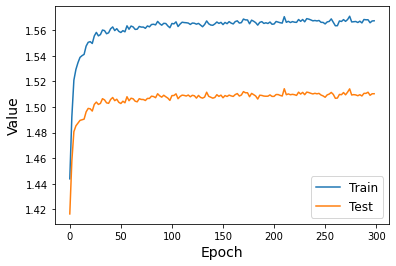

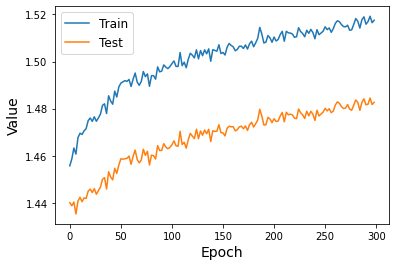

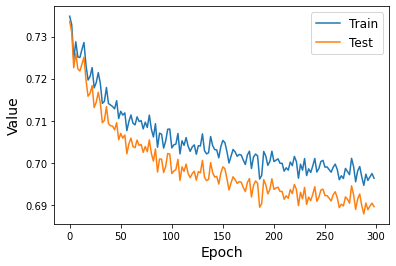

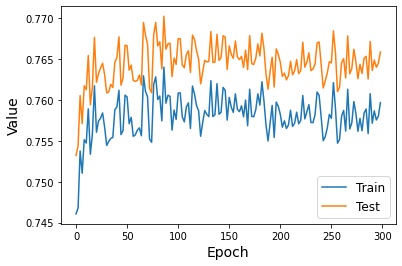

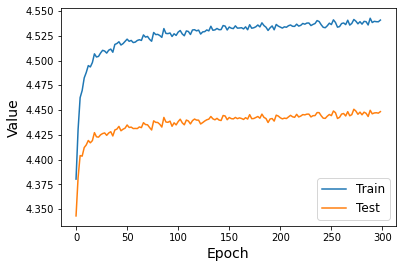

In [13]:
for i in range(5):
    plt.figure()
    plt.plot(2*np.arange(150), np.array(train_metrics_vals)[:, i], label='Train')
    plt.plot(2*np.arange(150), np.array(test_metrics_vals)[:, i], label='Test')
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Value", fontsize=14)
    plt.legend(prop={'size': 12})

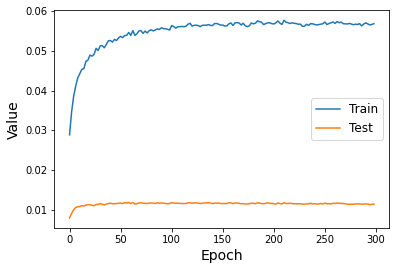

In [14]:
plt.figure()
plt.plot(2*np.arange(150), np.array(train_precision_vals), label='Train')
plt.plot(2*np.arange(150), np.array(precision_vals), label='Test')
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(prop={'size': 12})